In [1]:
%reload_ext autoreload
%autoreload 2
# %reload_ext tensorboard
# import os; os.environ['TENSORBOARD_BINARY']='../.new_env/bin/tensorboard'
# %tensorboard --logdir tensorboard/

In [59]:
from collections import namedtuple
import numpy as np
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D, GlobalAveragePooling2D, \
                         Dropout, Dense, Input, Concatenate, Flatten
from keras.callbacks import TensorBoard, Callback
from sklearn.preprocessing import LabelEncoder
from avian_vocalizations.data import AudioFeatureGenerator, load_data
from avian_vocalizations.visualization import show_sample
from avian_vocalizations.toolbench import print_module_versions
print_module_versions(globals())

             IPython  {'7.12.0'}
               numpy  {'1.18.1'}
               keras  {'2.3.1'}
             sklearn  {'0.22.1'}
 avian_vocalizations  {'0.1.0'}
              pandas  {'1.0.1'}


In [28]:
data_dir='../data'
index_df, shapes_df, train_df, test_df = load_data(data_dir)
label_encoder = LabelEncoder().fit(index_df['english_cname'] )
n_classes = len(label_encoder.classes_)
X_train = index_df.loc[index_df['test']==False].index.values
y_train = label_encoder.transform(index_df.loc[index_df['test']==False,"english_cname"].values)

In [108]:
def SGSimpleModel(n_classes, n_frames=128, dropout_rate=.2):
    sg_input = Input(shape=(128,n_frames,1),name='melsg')
    sg_pathway = Conv2D(64,3,name='sg_conv2d_1',
                         padding='valid',activation="relu")(sg_input)
    sg_pathway = MaxPooling2D(pool_size=3,name='sg_maxpooling_1')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate,name='sg_dropout_1')(sg_pathway)
    sg_pathway = Conv2D(64,3,padding='valid',activation="relu", 
                         name='sg_conv2d_2')(sg_pathway)
    sg_pathway = MaxPooling2D(pool_size=3,name='sg_maxpooling_2')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate, name='sg_dropout_2')(sg_pathway)
    sg_pathway = Conv2D(64,3,padding='valid',activation="relu", 
                         name='sg_conv2d_3')(sg_pathway)
    sg_pathway = MaxPooling2D(pool_size=3,name='sg_maxpooling_3')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate,name='sg_dropout_3')(sg_pathway)
    sg_pathway = GlobalAveragePooling2D(name='sg_globalaverage2d')(sg_pathway)
    sg_pathway = Dense(n_classes, activation='softmax', name='joined_output')(sg_pathway)

    model = Model(sg_input,sg_pathway)
    return model
SGSimpleModel(n_classes).summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melsg (InputLayer)           (None, 128, 128, 1)       0         
_________________________________________________________________
sg_conv2d_1 (Conv2D)         (None, 126, 126, 64)      640       
_________________________________________________________________
sg_maxpooling_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
sg_dropout_1 (Dropout)       (None, 42, 42, 64)        0         
_________________________________________________________________
sg_conv2d_2 (Conv2D)         (None, 40, 40, 64)        36928     
_________________________________________________________________
sg_maxpooling_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
sg_dropout_2 (Dropout)       (None, 13, 13, 64)        0  

In [106]:
ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=1/4, random_state=37)
train_idx, val_idx = next(ss.split(X_train, y_train))
print(train_idx.shape, val_idx.shape)

params=dict(n_classes=n_classes, batch_size=64, seed=37, n_frames=128, data_dir=data_dir)
training_generator = AudioFeatureGenerator(X_train[train_idx], y_train[train_idx], shuffle=True, **params)
validation_generator = AudioFeatureGenerator(X_train[val_idx], y_train[val_idx], shuffle=False, **params)

## Visualize generated data

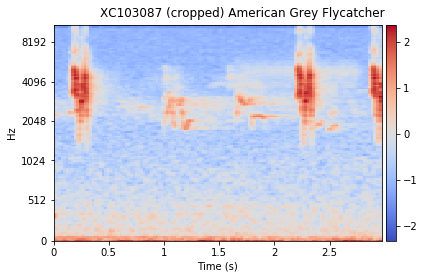

../data/audio/XC103087.mp3


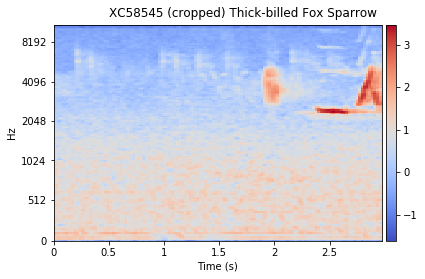

../data/audio/XC58545.mp3


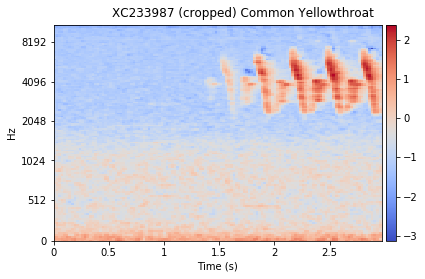

../data/audio/XC233987.mp3


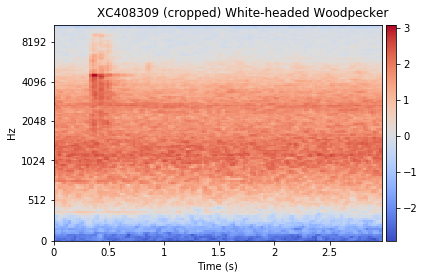

../data/audio/XC408309.mp3


In [83]:
Xs, ys = validation_generator[0] # first batch
for i in range(len(ys)): 
    label = label_encoder.classes_[np.argmax(ys[i])]
    show_sample(Xs['melsg'][i], file_id=Xs['id'][i], #Xs['mfcc'][i], 
                label='(cropped) '+label, #offset=Xs['offset'][i],
                data_dir="../data", load_clip=True )

## Train it

In [208]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import ModelCheckpoint
from datetime import datetime

def train_model(model, n_epochs=50, data_dir='../data', log_prefix=None, tensorboard_logdir="./tensorboard"):
    class StatusReporter(Callback):
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            print('epoch %i, '%epoch, end='')
            for k, v in logs.items(): # accuracy, val_accuracy, loss, val_loss
                if isinstance(v, (np.ndarray, np.generic)):
                    print('%s: %s  '%(k, v.item()), end='')
                else:
                    print('%s: %s  '%(k, v), end='')
            print()

    index_df, shapes_df, train_df, test_df = load_data(data_dir)
    label_encoder = LabelEncoder().fit(index_df['english_cname'] )
    n_classes = len(label_encoder.classes_)
    X_train = index_df.loc[index_df['test']==False].index.values
    y_train = label_encoder.transform(index_df.loc[index_df['test']==False,"english_cname"].values)
    
    ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=1/4, random_state=37)
    train_idx, val_idx = next(ss.split(X_train, y_train))
    
    params=dict(n_classes=n_classes, batch_size=256, seed=37, n_frames=128, data_dir=data_dir)
    training_generator = AudioFeatureGenerator(X_train[train_idx], y_train[train_idx], shuffle=True, **params)
    validation_generator = AudioFeatureGenerator(X_train[val_idx], y_train[val_idx], shuffle=False, **params)
    
    if log_prefix is None:
        log_prefix = "model_training"
    tensorboard_logdir = "%s/%s_%s"%(
        tensorboard_logdir,
        log_prefix,
        datetime.now().strftime("%Y-%m-%dT%H:%M:%S"))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    learning = model.fit_generator(
                training_generator, 
                validation_data=validation_generator,
                epochs=n_epochs, 
                steps_per_epoch=training_generator.n_batches,
                validation_steps=validation_generator.n_batches,
                callbacks=[
                    StatusReporter(), 
                    TensorBoard(log_dir=tensorboard_logdir),
                ], 
                #use_multiprocessing=True, workers=4,
                verbose=0, )
    acc_at_min_loss = learning.history['val_accuracy'][np.argmin(learning.history['val_loss'])]
    print("min loss: %.5f, accuracy at min loss: %.5f"%(
        np.min(learning.history['val_loss']), acc_at_min_loss ))

In [ ]:
def ExpSgModel(n_classes, n_frames=128, dropout_rate=.2):
    sg_input = Input(shape=(128,n_frames,1),name='melsg')
    sg_pathway = Conv2D(64,3,name='sg_conv2d_1',
                         padding='valid',activation="relu")(sg_input)
    sg_pathway = MaxPooling2D(pool_size=3,name='sg_maxpooling_1')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate,name='sg_dropout_1')(sg_pathway)
    sg_pathway = Conv2D(64,3,padding='valid',activation="relu", 
                         name='sg_conv2d_2')(sg_pathway)
    sg_pathway = MaxPooling2D(pool_size=3,name='sg_maxpooling_2')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate, name='sg_dropout_2')(sg_pathway)
    sg_pathway = Conv2D(64,3,padding='valid',activation="relu", 
                         name='sg_conv2d_3')(sg_pathway)
    sg_pathway = MaxPooling2D(pool_size=3,name='sg_maxpooling_3')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate,name='sg_dropout_3')(sg_pathway)
    sg_pathway = GlobalAveragePooling2D(name='sg_globalaverage2d')(sg_pathway)
    sg_pathway = Dense(n_classes, activation='softmax', name='joined_output')(sg_pathway)

    model = Model(sg_input,sg_pathway)
    return model
ExpSgModel(n_classes).summary()

In [227]:
def ExpMFCCModel(n_classes, n_frames=128, dropout_rate=.2, include_top=True):
    mfcc_input = Input(shape=(20,n_frames,1),name='mfcc')
    mfcc_pathway = Conv2D(16,(1,3),name='mfcc_conv2d_1',
                         padding='valid',activation="relu")(mfcc_input)
    mfcc_pathway = MaxPooling2D(pool_size=(1,2),name='mfcc_maxpooling_1')(mfcc_pathway)
    mfcc_pathway = Dropout(rate=dropout_rate,name='mfcc_dropout_1')(mfcc_pathway)
    mfcc_pathway = Conv2D(32,(1,3),padding='valid',activation="relu", 
                         name='mfcc_conv2d_2')(mfcc_pathway)
    mfcc_pathway = MaxPooling2D(pool_size=(1,2),name='mfcc_maxpooling_2')(mfcc_pathway)
    mfcc_pathway = Dropout(rate=dropout_rate, name='mfcc_dropout_2')(mfcc_pathway)
    mfcc_pathway = Conv2D(64,(20,1),padding='valid',activation="relu", 
                         name='mfcc_conv2d_3')(mfcc_pathway)
    mfcc_pathway = MaxPooling2D(pool_size=(1,2),name='mfcc_maxpooling_3')(mfcc_pathway)
    mfcc_pathway = Dropout(rate=dropout_rate,name='mfcc_dropout_3')(mfcc_pathway)
    if include_top:
        mfcc_pathway = GlobalAveragePooling2D(name='mfcc_globalaverage2d')(mfcc_pathway)
        mfcc_pathway = Dense(n_classes, activation='softmax', name='output')(mfcc_pathway)
    else:    
        return mfcc_input, mfcc_pathway

    model = Model(mfcc_input,mfcc_pathway)
    return model
ExpMFCCModel(n_classes).summary()

Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfcc (InputLayer)            (None, 20, 128, 1)        0         
_________________________________________________________________
mfcc_conv2d_1 (Conv2D)       (None, 20, 126, 16)       64        
_________________________________________________________________
mfcc_maxpooling_1 (MaxPoolin (None, 20, 63, 16)        0         
_________________________________________________________________
mfcc_dropout_1 (Dropout)     (None, 20, 63, 16)        0         
_________________________________________________________________
mfcc_conv2d_2 (Conv2D)       (None, 20, 61, 32)        1568      
_________________________________________________________________
mfcc_maxpooling_2 (MaxPoolin (None, 20, 30, 32)        0         
_________________________________________________________________
mfcc_dropout_2 (Dropout)     (None, 20, 30, 32)        0  

In [155]:
model = ExpMFCCModel(n_classes)
train_model(model, tensorboard_logdir='./tensorboard/ExpMFCCModel')

epoch 0, val_loss: 4.506420135498047  val_accuracy: 0.010989011265337467  loss: 4.521383216354873  accuracy: 0.009523809887468815  
epoch 1, val_loss: 4.5047760009765625  val_accuracy: 0.008791209198534489  loss: 4.506015369568989  accuracy: 0.01245421264320612  
epoch 2, val_loss: 4.502788543701172  val_accuracy: 0.015384615398943424  loss: 4.499201319418547  accuracy: 0.021245421841740608  
epoch 3, val_loss: 4.500666618347168  val_accuracy: 0.02637362666428089  loss: 4.4940141192286  accuracy: 0.016117217019200325  
epoch 4, val_loss: 4.4945597648620605  val_accuracy: 0.024175824597477913  loss: 4.4853432187230595  accuracy: 0.02857142873108387  
epoch 5, val_loss: 4.48421049118042  val_accuracy: 0.032967034727334976  loss: 4.476321963774852  accuracy: 0.02637362666428089  
epoch 6, val_loss: 4.471241474151611  val_accuracy: 0.032967034727334976  loss: 4.465085877778329  accuracy: 0.0336996354162693  
epoch 7, val_loss: 4.458425045013428  val_accuracy: 0.03956044092774391  loss: 4.4

KeyboardInterrupt: 

In [228]:
def ExpSgModel(n_classes, n_frames=128, dropout_rate=.2, include_top=True):
    sg_input = Input(shape=(128,n_frames,1),name='melsg')
    sg_pathway = Conv2D(16,3,name='sg_conv2d_1',
                         padding='valid',activation="relu")(sg_input)
    sg_pathway = MaxPooling2D(pool_size=2,name='sg_maxpooling_1')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate,name='sg_dropout_1')(sg_pathway)
    sg_pathway = Conv2D(32,3,padding='valid',activation="relu", 
                         name='sg_conv2d_2')(sg_pathway)
    sg_pathway = MaxPooling2D(pool_size=2,name='sg_maxpooling_2')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate, name='sg_dropout_2')(sg_pathway)
    sg_pathway = Conv2D(64,(30,1),padding='valid',activation="relu", 
                         name='sg_conv2d_3')(sg_pathway)
    sg_pathway = MaxPooling2D(pool_size=(1,2),name='sg_maxpooling_3')(sg_pathway)
    sg_pathway = Dropout(rate=dropout_rate,name='sg_dropout_3')(sg_pathway)
    if include_top:
        sg_pathway = GlobalAveragePooling2D(name='sg_globalaverage2d')(sg_pathway)
        sg_pathway = Dense(n_classes, activation='softmax', name='output')(sg_pathway)
    else:    
        return sg_input, sg_pathway

    model = Model(sg_input, sg_pathway, name='ExpSgModel')
    return model
ExpSgModel(n_classes).summary()

Model: "ExpSgModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melsg (InputLayer)           (None, 128, 128, 1)       0         
_________________________________________________________________
sg_conv2d_1 (Conv2D)         (None, 126, 126, 16)      160       
_________________________________________________________________
sg_maxpooling_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
sg_dropout_1 (Dropout)       (None, 63, 63, 16)        0         
_________________________________________________________________
sg_conv2d_2 (Conv2D)         (None, 61, 61, 32)        4640      
_________________________________________________________________
sg_maxpooling_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
sg_dropout_2 (Dropout)       (None, 30, 30, 32)        0

In [209]:
model = ExpSgModel(n_classes)
train_model(model, log_prefix='ExpSgModel')

epoch 0, val_loss: 4.490594863891602  val_accuracy: 0.017582418397068977  loss: 4.525658899873168  accuracy: 0.01245421264320612  
epoch 1, val_loss: 4.478735446929932  val_accuracy: 0.024175824597477913  loss: 4.48935650731181  accuracy: 0.01684981770813465  
epoch 2, val_loss: 4.456701755523682  val_accuracy: 0.024175824597477913  loss: 4.462726644369272  accuracy: 0.03589743748307228  
epoch 3, val_loss: 4.428840637207031  val_accuracy: 0.03076923079788685  loss: 4.43848455450037  accuracy: 0.030036630108952522  
epoch 4, val_loss: 4.391671657562256  val_accuracy: 0.03956044092774391  loss: 4.393850835164388  accuracy: 0.0476190485060215  
epoch 5, val_loss: 4.35831880569458  val_accuracy: 0.048351649194955826  loss: 4.3487660872630585  accuracy: 0.04615384712815285  
epoch 6, val_loss: 4.3303141593933105  val_accuracy: 0.05274725332856178  loss: 4.29139958406106  accuracy: 0.06227106228470802  
epoch 7, val_loss: 4.290020942687988  val_accuracy: 0.05494505539536476  loss: 4.2431629

KeyboardInterrupt: 

In [236]:
def ExpCombinedModel(n_classes, n_frames=128, dropout_rate=.2):
    
    sg_input, sg_pathway = ExpSgModel(n_classes, n_frames, dropout_rate, include_top=False)

    mfcc_input, mfcc_pathway = ExpMFCCModel(n_classes, n_frames, dropout_rate, include_top=False)

    joined = Concatenate(axis=-1,name='joined_sg_mfc')([sg_pathway, mfcc_pathway])
    joined = Dense(128, name='joined_dense1', activation='relu')(joined)
    joined = Dense(128, name='joined_dense2', activation='relu')(joined)
    joined = GlobalAveragePooling2D(name='joined_globalaverage2d')(joined)
    joined = Dense(n_classes, activation='softmax', name='joined_output')(joined)

    model = Model([sg_input, mfcc_input], joined)
    return model
ExpCombinedModel(n_classes).summary()

Model: "model_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melsg (InputLayer)              (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
mfcc (InputLayer)               (None, 20, 128, 1)   0                                            
__________________________________________________________________________________________________
sg_conv2d_1 (Conv2D)            (None, 126, 126, 16) 160         melsg[0][0]                      
__________________________________________________________________________________________________
mfcc_conv2d_1 (Conv2D)          (None, 20, 126, 16)  64          mfcc[0][0]                       
___________________________________________________________________________________________

In [237]:
model = ExpCombinedModel(n_classes)
train_model(model, log_prefix='ExpCombinedModel')

epoch 0, val_loss: 4.495217800140381  val_accuracy: 0.021978022530674934  loss: 4.5147757090055025  accuracy: 0.011721611954271793  
epoch 1, val_loss: 4.478978633880615  val_accuracy: 0.021978022530674934  loss: 4.492802035153567  accuracy: 0.019780220463871956  
epoch 2, val_loss: 4.451328277587891  val_accuracy: 0.02637362666428089  loss: 4.460359686198252  accuracy: 0.02637362666428089  
epoch 3, val_loss: 4.394377708435059  val_accuracy: 0.03956044092774391  loss: 4.4156067215916  accuracy: 0.029304029420018196  
epoch 4, val_loss: 4.330441951751709  val_accuracy: 0.04175824299454689  loss: 4.35334070121849  accuracy: 0.03809523954987526  
epoch 5, val_loss: 4.294108867645264  val_accuracy: 0.04615384712815285  loss: 4.27581406373244  accuracy: 0.04175824299454689  
epoch 6, val_loss: 4.260170936584473  val_accuracy: 0.04395604506134987  loss: 4.209875010046767  accuracy: 0.05494505539536476  
epoch 7, val_loss: 4.242455005645752  val_accuracy: 0.04615384712815285  loss: 4.1608475